In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay




In [ ]:
import sys

sys.path.append('../src')

from data_preprocessing import X, y



kNN

*Cross validation*
rekommenderas för kNN

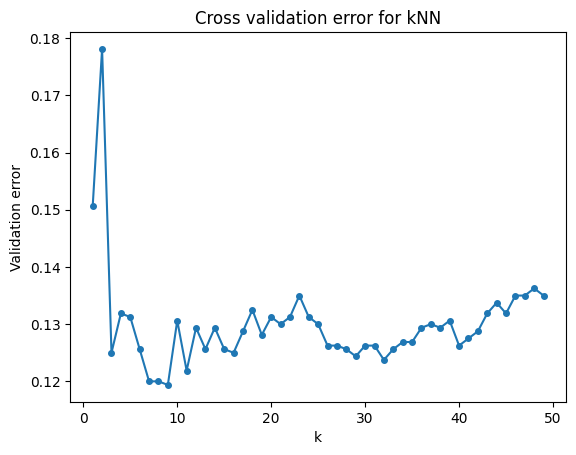

Average accuracy for 2: 0.875
Average accuracy for 3: 0.868
Average accuracy for 4: 0.869
Average accuracy for 5: 0.874
Average accuracy for 6: 0.880
Average accuracy for 7: 0.880
Average accuracy for 8: 0.881
Average accuracy for 9: 0.869


In [172]:
day_cols = [c for c in X.columns if c.startswith("day_")]
binary_cols = ["snow_or_not", "summertime"]
cols_to_scale = [c for c in X.columns if c not in day_cols + binary_cols]

preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), cols_to_scale)],
    remainder="passthrough",
)

cv = skl_ms.StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
K = np.arange(1, 50)
misclassification = np.zeros(len(K))

for j, k in enumerate(K):
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", skl_nb.KNeighborsClassifier(n_neighbors=k)),
    ])
    scores = skl_ms.cross_val_score(pipeline, X, y, cv=cv)
    misclassification[j] = 1 - np.mean(scores)

plt.plot(K, misclassification, marker='o', markersize=4)
plt.title('Cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('Validation error')
plt.show()

for k_index in range(2,10):
    print(f"Average accuracy for {k_index}: {1 - misclassification[k_index]:.3f}")

k=2: high=0.75000, low=0.83765
k=3: high=0.57292, low=0.94131
k=4: high=0.68750, low=0.90777
k=5: high=0.54514, low=0.93979
k=6: high=0.68403, low=0.91616
k=7: high=0.57986, low=0.94588
k=8: high=0.65625, low=0.92912
k=9: high=0.56597, low=0.94970


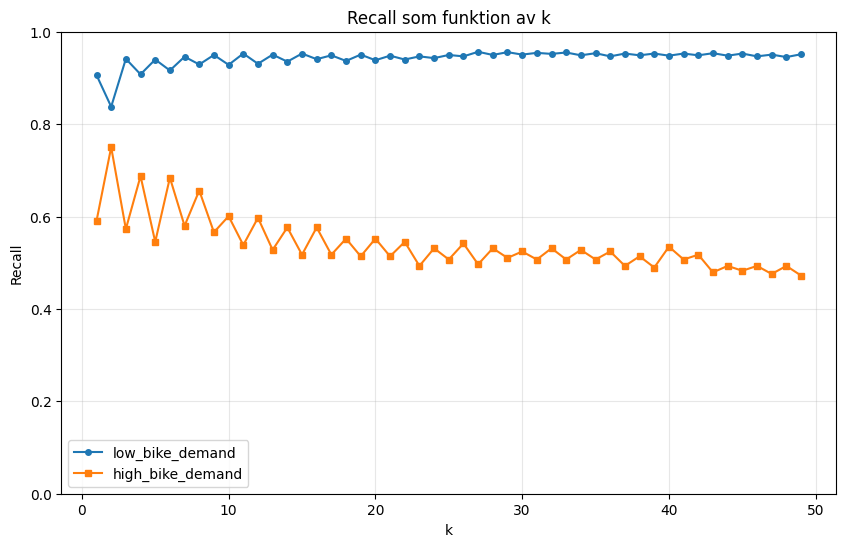

In [ ]:
K = np.arange(1, 50)
recall_low = []
recall_high = []

for k in K:
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", skl_nb.KNeighborsClassifier(n_neighbors=k)),
    ])
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    report = classification_report(y, y_pred, output_dict=True)
    
    recall_low.append(report.get("low_bike_demand", {}).get("recall", 0))
    recall_high.append(report.get("high_bike_demand", {}).get("recall", 0))

for k_value in range(2, 10):
    k_index = k_value - 1
    print(f"k={k_value}: high={recall_high[k_index]:.5f}, low={recall_low[k_index]:.5f}")

plt.figure(figsize=(10, 6))
plt.plot(K, recall_low, label="low_bike_demand", marker='o', markersize=4)
plt.plot(K, recall_high, label="high_bike_demand", marker='s', markersize=4)
plt.title("Recall som funktion av k")
plt.xlabel("k")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# gjort för grid search
''' day_cols = [c for c in X.columns if c.startswith("day_")]
binary_cols = ["snow_or_not", "summertime"]
cols_to_scale = [c for c in X.columns if c not in day_cols + binary_cols]

preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), cols_to_scale)],
    remainder="passthrough",
)
cv = skl_ms.StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
K = np.arange(1, 50) '''

In [ ]:

#BS grid search fuck den och ta bort
'''param_grid = {
    'model__n_neighbors': np.arange(1, 25),  
    'model__weights': ['uniform', 'distance'],  
    'model__metric': ['euclidean', 'manhattan']  
}

# Pipeline
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", skl_nb.KNeighborsClassifier())
])

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=cv, 
    scoring={
        'recall_high': make_scorer(recall_score, pos_label="high_bike_demand"),
        'accuracy': 'accuracy'
    },
    refit='recall_high',  
    n_jobs=-1  
)

grid_search.fit(X, y)

print(f"Bästa parametrar: {grid_search.best_params_}")
print(f"Bästa accuracy: {grid_search.best_score_:.4f}")

# Visualisera resultaten
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_model__n_neighbors', 'param_model__weights',  'mean_test_recall_high', 'mean_test_accuracy']])''' 

In [171]:
final_kNN = Pipeline([
    ("preprocess", preprocessor),
    ("model", skl_nb.KNeighborsClassifier(n_neighbors=16))
])

y_pred = cross_val_predict(final_kNN, X, y, cv=cv)


                  precision    recall  f1-score   support

high_bike_demand       0.68      0.58      0.62       288
 low_bike_demand       0.91      0.94      0.93      1312

        accuracy                           0.88      1600
       macro avg       0.80      0.76      0.77      1600
    weighted avg       0.87      0.88      0.87      1600



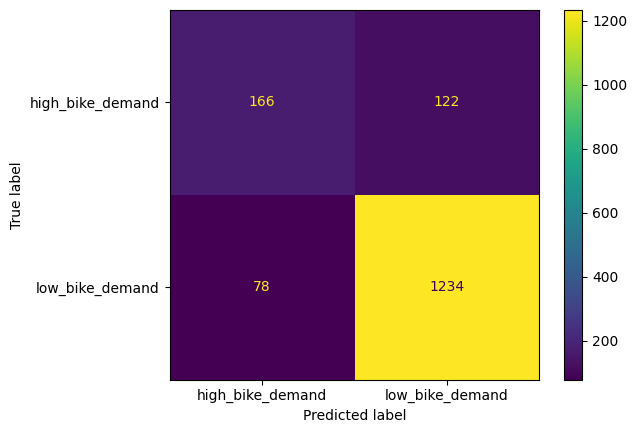

In [152]:
# - Cross-validation --------------------------------
y_pred = cross_val_predict(final_kNN, X, y, cv=cv)  

# Classification report
print(classification_report(y, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.show()

In [126]:
# ta bort denna skit

from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

def knn_variant_scores(X, y, k=6, cv_splits=10, random_state=1):
    day_cols = [c for c in X.columns if c.startswith("day_")]
    binary_cols = [c for c in X.columns if c in ["snow_or_not", "summertime"]]
    cols_to_scale = [c for c in X.columns if c not in day_cols + binary_cols]

    preprocessor = ColumnTransformer(
        transformers=[("scale", StandardScaler(), cols_to_scale)],
        remainder="passthrough",
    )

    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", skl_nb.KNeighborsClassifier(n_neighbors=k)),
    ])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=cv,
        scoring={
            "recall_low": make_scorer(recall_score, pos_label="low_bike_demand"),
            "recall_high": make_scorer(recall_score, pos_label="high_bike_demand"),
        },
    )
    return scores["test_recall_low"].mean(), scores["test_recall_high"].mean()

base_df = X.copy()
variants = {"original": base_df}

if "windspeed" in base_df.columns:
    df_wind = base_df.copy()
    df_wind["windspeed_sqrt"] = np.sqrt(df_wind["windspeed"])
    variants["windspeed_sqrt"] = df_wind

for col_name, label in [("humidity", "no_humidity"), ("summertime", "no_summertime")]:
    if col_name in base_df.columns:
        df_drop = base_df.drop(columns=[col_name])
        variants[label] = df_drop

if "weekday" in base_df.columns:
    variants["no_weekday"] = base_df.drop(columns=["weekday"])

k_value = 6
for name, data in variants.items():
    recall_low, recall_high = knn_variant_scores(data, y, k=k_value)
    print(
        f"{name}: k={k_value} | recall low={recall_low:.4f} | "
        f"recall high={recall_high:.4f}"
    )

original: k=6 | recall low=0.9177 | recall high=0.6633
windspeed_sqrt: k=6 | recall low=0.9085 | recall high=0.6458
no_humidity: k=6 | recall low=0.9238 | recall high=0.6181
no_summertime: k=6 | recall low=0.9154 | recall high=0.6597
